# Lab ML for DS SS23
## Project 2
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [1]:
import pandas as pd
import numpy as np
import math

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.io import loadmat
from scipy.spatial.distance import cdist, pdist


# 1. Importing the QM7 Dataset

In [2]:
# The QM7 dataset consists of 7165 organic molecules, each of which is composed of up to 23 atoms.
qm7 = loadmat("./qm7.mat")
print(qm7.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'R', 'Z', 'T', 'P'])


In [3]:
# R (7165×23×3) contains for each molecule and atom a triplet representing the 3d coordinates
display(qm7['R'].shape)
display(qm7['R'][0])

(7165, 23, 3)

array([[ 1.886438  , -0.00464873, -0.00823921],
       [ 3.9499245 , -0.00459203,  0.00782347],
       [ 1.1976895 ,  1.9404842 ,  0.00782347],
       [ 1.1849339 , -0.99726516,  1.6593875 ],
       [ 1.2119948 , -0.9589793 , -1.710958  ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [4]:
# Z (7165×23) contains for each molecule and atom of the molecule the corresponding atomic number

# 0 == no atom at this index
# 1 == hydrogen (H)
# 6 == carbon (C)
# 7 == nitrogen (N) 
# 8 == oxygen (O)
# 16 == sulfur (S)
display(qm7['Z'].shape)
display(qm7['Z'][0])

(7165, 23)

array([6., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

(1, 7165)

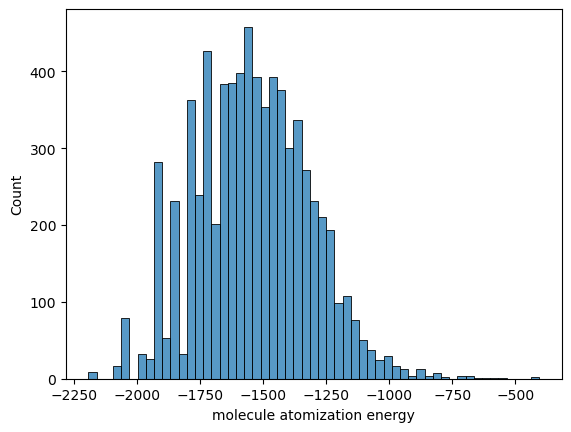

In [5]:
# T (1 x 7165) contains for each molecule the atomization energy (computed via quantum-chemical simulation)
display(qm7['T'].shape)

g = sns.histplot(qm7['T'][0])
g.set_xlabel('molecule atomization energy')
plt.show()

# TESTS FOR 1.1 Visualizing Molecules "quick and dirty approach"

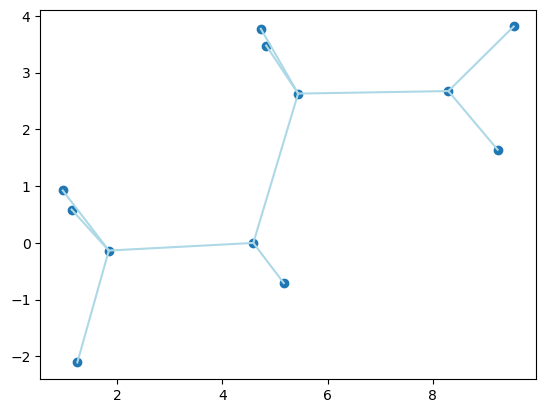

In [6]:
nr = 100

mol = qm7["R"][nr]
sym = qm7["Z"][nr]

sym = sym[sym > 0]
mol = mol[: len(sym)]

plt.scatter(x=mol[:, 0], y=mol[:, 1])


# generate bonds
thresh = 3

mask = np.argwhere(pdist(mol, metric="euclidean") < thresh)[:, 0]
bonds = np.vstack(np.triu_indices(len(mol), 1)).T[mask]

for i in range(len(bonds)):
    plt.plot(mol[bonds[i]][:, 0], mol[bonds[i]][:, 1], color="lightblue")


In [7]:
from ase import Atoms
import nglview
import ase.visualize

system = Atoms(positions=mol, symbols=sym)
# ase.visualize.view(system, viewer="x3d")

view = nglview.show_ase(system)
view.add_ball_and_stick() # HOW TO SPECIFY BONDS?????
view


NGLWidget()

In [8]:
# Other viz approaches
# https://www.kaggle.com/code/mykolazotko/3d-visualization-of-molecules-with-plotly
# nglview


# 2 Data Representation, ML Model and Explanations

# TEST FOR 2.1 Data Representation

In [11]:
# first try described representation
# 1 == hydrogen (H)
# 6 == carbon (C)
# 7 == nitrogen (N) 
# 8 == oxygen (O)
# 16 == sulfur (S)


z = qm7['Z'].astype(np.int8)

z[z == 1] = 1
z[z == 6] = 2
z[z == 7] = 3
z[z == 8] = 4
z[z == 16] = 5

Z_hot = np.eye(6)[z]
del z

Z_hot = Z_hot[:, :, 1:] # drop 0 dimension

x = np.sum(Z_hot, axis=1)

display(x.shape)
x


(7165, 5)

array([[ 4.,  1.,  0.,  0.,  0.],
       [ 6.,  2.,  0.,  0.,  0.],
       [ 4.,  2.,  0.,  0.,  0.],
       ...,
       [ 9.,  6.,  1.,  0.,  0.],
       [10.,  7.,  0.,  0.,  0.],
       [12.,  7.,  0.,  0.,  0.]])

# TEST FOR 2.2 Ridge Regression Model

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

# split train / test 
X_train, X_test, y_train, y_test = train_test_split(x, qm7['T'][0], test_size=0.3, random_state=42)

# center data and target
X_train_mean = np.mean(X_train, axis=0)
y_train_mean = np.mean(y_train)

X_train = X_train - X_train_mean
X_test = X_test - X_train_mean

y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

In [170]:
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedKFold, GridSearchCV

ridge = Ridge(alpha=1.0)

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

# scores = cross_validate(ridge, X_train, y_train, cv=cv, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), return_train_score=True)
# scores.keys()

alpha_values = np.log(np.logspace(0, 5, 100, base=np.e))
grid = dict(alpha = alpha_values)
search = GridSearchCV(ridge, grid, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), cv=cv, n_jobs=-1, refit = 'neg_mean_squared_error')

results = search.fit(X_train, y_train)


In [148]:
display(results.cv_results_.keys())

results.cv_results_['mean_test_r2']

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'split5_test_r2', 'split6_test_r2', 'split7_test_r2', 'split8_test_r2', 'split9_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2', 'split0_test_neg_mean_squared_error', 'split1_test_neg_mean_squared_error', 'split2_test_neg_mean_squared_error', 'split3_test_neg_mean_squared_error', 'split4_test_neg_mean_squared_error', 'split5_test_neg_mean_squared_error', 'split6_test_neg_mean_squared_error', 'split7_test_neg_mean_squared_error', 'split8_test_neg_mean_squared_error', 'split9_test_neg_mean_squared_error', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'split0_test_neg_mean_absolute_error', 'split1_test_neg_mean_absolute_error', 'split2_test_neg_mean_absolute_error', 'split3_test_neg_mean_absolute_error', 'split4_test_neg_mean_ab

array([0.99177535, 0.99177535, 0.99177533, 0.99177532, 0.9917753 ,
       0.99177527, 0.99177524, 0.99177521, 0.99177517, 0.99177513,
       0.99177508, 0.99177504, 0.99177498, 0.99177492, 0.99177486,
       0.99177479, 0.99177472, 0.99177465, 0.99177457, 0.99177449,
       0.9917744 , 0.99177431, 0.99177422, 0.99177412, 0.99177402,
       0.99177391, 0.9917738 , 0.99177368, 0.99177356, 0.99177344,
       0.99177332, 0.99177318, 0.99177305, 0.99177291, 0.99177277,
       0.99177262, 0.99177247, 0.99177232, 0.99177216, 0.99177199,
       0.99177183, 0.99177166, 0.99177148, 0.9917713 , 0.99177112,
       0.99177094, 0.99177075, 0.99177055, 0.99177035, 0.99177015,
       0.99176995, 0.99176974, 0.99176952, 0.99176931, 0.99176908,
       0.99176886, 0.99176863, 0.9917684 , 0.99176816, 0.99176792,
       0.99176768, 0.99176743, 0.99176718, 0.99176692, 0.99176666,
       0.9917664 , 0.99176613, 0.99176586, 0.99176558, 0.99176531,
       0.99176502, 0.99176474, 0.99176445, 0.99176415, 0.99176

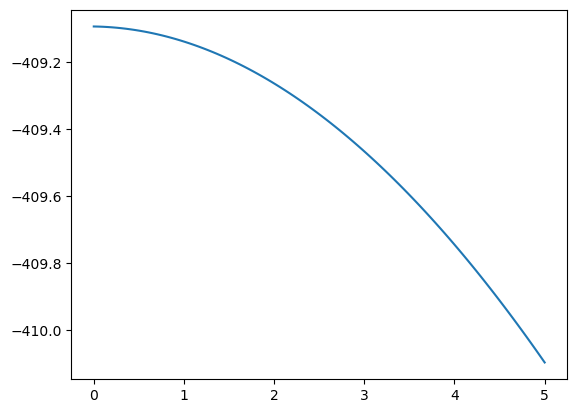

In [162]:
ax = sns.lineplot(x = alpha_values, y=results.cv_results_['mean_test_neg_mean_squared_error'], errorbar=None)

<ErrorbarContainer object of 3 artists>

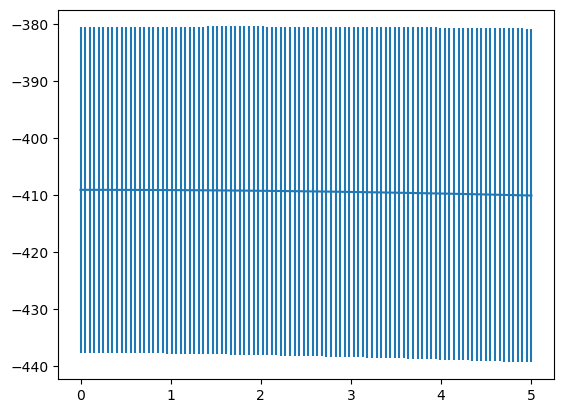

In [161]:
plt.errorbar(x = alpha_values, y=results.cv_results_['mean_test_neg_mean_squared_error'], yerr=results.cv_results_['std_test_neg_mean_squared_error'])

<AxesSubplot: xlabel='alpha', ylabel='score'>

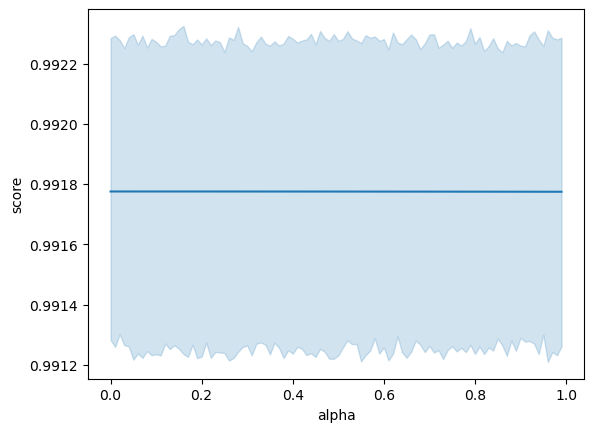

In [118]:
# s = np.concatenate([results.cv_results_['split' + str(i) + '_test_r2'] for i in range(10)])

# a = np.concatenate([grid['alpha'] for i in range(10)])

# d = pd.DataFrame({'alpha':a, 'score':s})

# sns.lineplot(data = d, x='alpha', y='score')


R2: 0.9919575972670127
MSE: 403.69255234309014
MAE: 15.467094890807335


<AxesSubplot: >

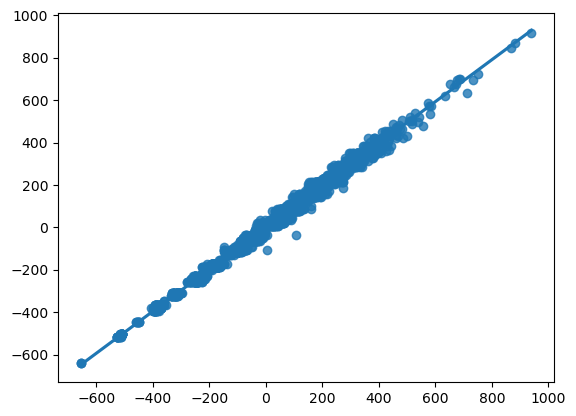

In [169]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
sns.regplot(x=y_test, y=y_pred)

In [177]:
# TEST - USE RIDGECV

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
model = RidgeCV(alphas=np.arange(0.01, 5, 0.01), cv=cv, scoring='neg_mean_absolute_error')
model.fit(X_train, y_train)
print('alpha: %f' % model.alpha_)

alpha: 0.010000
